In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

In [2]:
#The dataset 

#Reading the dataset
data= pd.read_csv(r"C:\Users\chait\Desktop\project_575\OnlineNewsPopularity_Dataset\OnlineNewsPopularity.csv")

#dimensions and other details
#data.shape (39644, 61)
#data.info()
#data.describe()

#Removing space character from the variable names
data.columns=data.columns.str.replace(" ","")

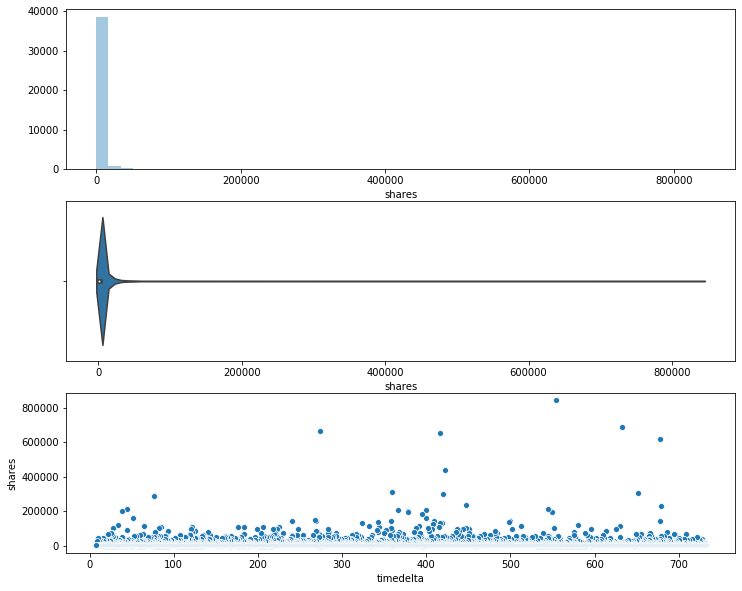

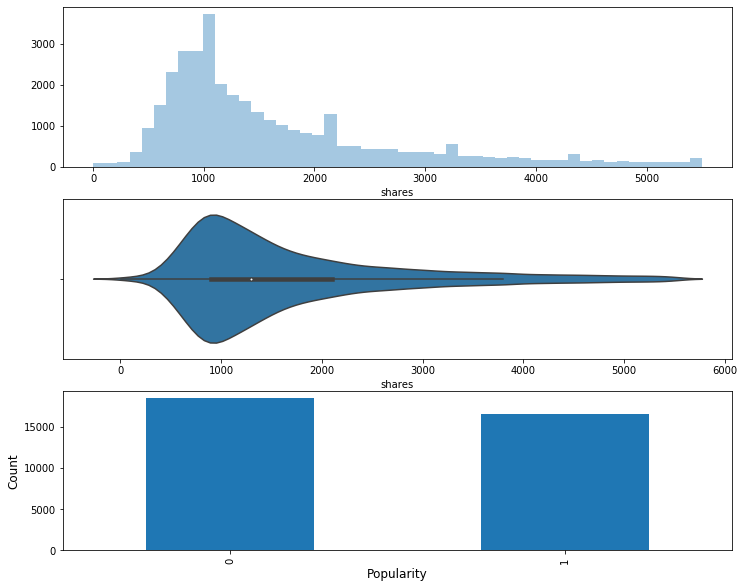

In [3]:
#1)Understanding target variable distribution 

#Checking median since dsitribution is highly skewed and median to covert to binary classification
#data.describe()
data['shares'].median() #1400

plt.subplots(3,1,figsize=(12,10))
plt.subplot(3,1,1)
sns.distplot(data['shares'], hist=True, kde=False)
plt.subplot(3,1,2)
sns.violinplot(data['shares'])
plt.subplot(3,1,3)
sns.scatterplot(data=data, x='timedelta', y='shares')

#Removing highlighy skewed rows
Q1 = data['shares'].quantile(0.25)
Q3 = data['shares'].quantile(0.75)
IQR = Q3 - Q1
LTV= Q1 - (1.5 * IQR)
UTV= Q3 + (1.5 * IQR)
data = data.drop(data[data['shares'] > UTV].index)
data.shape #35103

#After removal distribution
plt.subplots(3,1,figsize=(12,10))
plt.subplot(3,1,1)
sns.distplot(data['shares'], hist=True, kde=False)
plt.subplot(3,1,2)
sns.violinplot(data['shares'])
plt.subplot(3,1,3)
sns.scatterplot(data=data, x='timedelta', y='shares')

#Coverting to a binary classfication problem
#creating new target variable based on median
data['popularity'] = data['shares'].apply(lambda x: 0 if x<1400 else 1)

#distribution of popular and not popular articles
popularity_count=data.groupby("popularity").count()
popularity_count['url'].plot(kind='bar')
plt.xlabel("Popularity", fontsize=12)
plt.ylabel("Count", fontsize=12)
#plt.grid(True)

#popular and unpopular rows
Unpopular=data[data['popularity']==0]
Popular=data[data['popularity']==1]

In [4]:
#Final number of rows
data.shape #35103

(35103, 62)

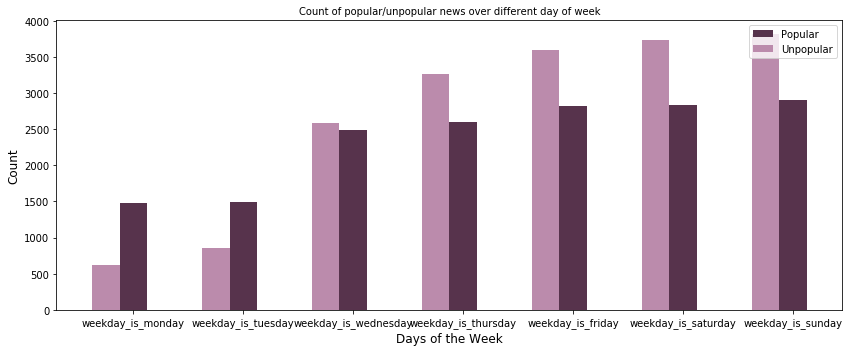

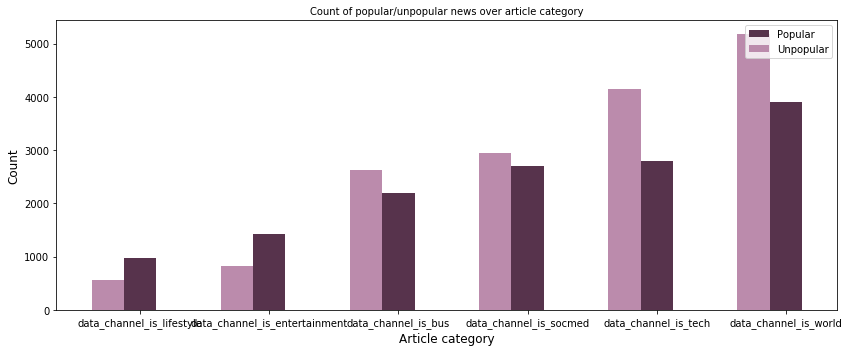

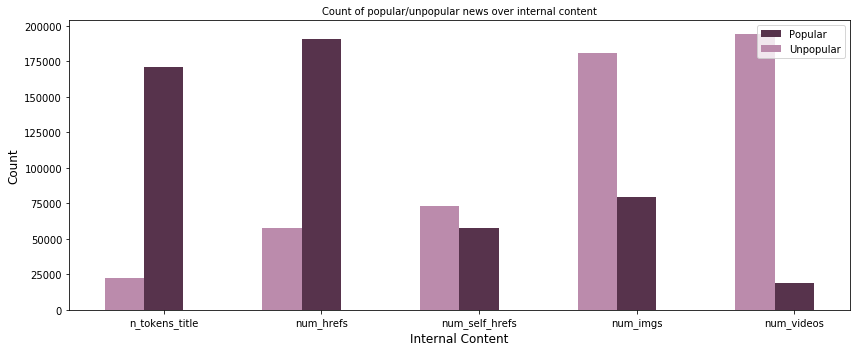

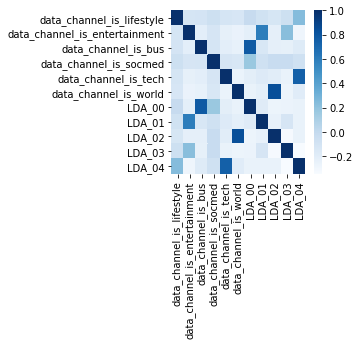

In [5]:
#2) Data exploration

#a)distribution of articles over days of week
days_of_week = data.columns.values[31:38]
Unpopular_days = Unpopular[days_of_week].sum()
Unpopular_days=np.sort(Unpopular_days, False)
Popular_days = Popular[days_of_week].sum().values
Popular_days=np.sort(Popular_days, False)

fig = plt.figure(figsize = (12,5))
plt.title("Count of popular/unpopular news over different day of week", fontsize = 10)

plt.bar(np.arange(len(days_of_week)),Popular_days,width=0.25,align='center',color='#57334c',label='Popular')
plt.bar(np.arange(len(days_of_week))-0.25,Unpopular_days,width=0.25,align='center',color='#bb8bac',label='Unpopular')

plt.xticks(np.arange(len(days_of_week)),days_of_week)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Days of the Week',fontsize=12)

plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

#b)distribution of articles over category
content = data.columns.values[13:19]
Unpopular_content = Unpopular[content].sum().values
Unpopular_content=np.sort(Unpopular_content, False)
Popular_content = Popular[content].sum().values
Popular_content = np.sort(Popular_content, False)

fig = plt.figure(figsize = (12,5))
plt.title("Count of popular/unpopular news over article category", fontsize = 10)

plt.bar(np.arange(len(content)),Popular_content,width=0.25,align='center',color='#57334c',label='Popular')
plt.bar(np.arange(len(content))-0.25,Unpopular_content,width=0.25,align='center',color='#bb8bac',label='Unpopular')

plt.xticks(np.arange(len(content)),content)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Article category',fontsize=12)

plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

#c)Distibution of popularity based on internal content of article
Internal_content = data[['n_tokens_title','num_hrefs','num_self_hrefs','num_imgs','num_videos']].columns

Unpopular_internal_content = Unpopular[Internal_content].sum().values
Unpopular_internal_content =np.sort(Unpopular_internal_content, False)

Popular_internal_content = Popular[Internal_content].sum().values
Popular_content = np.sort(Popular_internal_content, False)

fig = plt.figure(figsize = (12,5))
plt.title("Count of popular/unpopular news over internal content", fontsize = 10)

plt.bar(np.arange(len(Internal_content)),Popular_internal_content,width=0.25,align='center',color='#57334c',label='Popular')
plt.bar(np.arange(len(Internal_content))-0.25,Unpopular_internal_content,width=0.25,align='center',color='#bb8bac',label='Unpopular')

plt.xticks(np.arange(len(Internal_content)),Internal_content)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Internal Content',fontsize=12)

plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

#d)Checking correlations between LDA and article categories.
Corr_Colums = data[['data_channel_is_lifestyle','data_channel_is_entertainment','data_channel_is_bus','data_channel_is_socmed','data_channel_is_tech','data_channel_is_world','LDA_00','LDA_01','LDA_02','LDA_03','LDA_04']]
corr_col=Corr_Colums.corr()
plt.figure(figsize=(3,3))
sns.heatmap(corr_col, annot=False, cmap='Blues')


In [6]:
#Data Preparation
Original_data=data

#1)Drop non predictive columns since they dont contribute to prediciton
data=data.drop(data[['url','timedelta']], axis=1)

#2)Removing rows with zero tokens in content-means we remove articles with no proper wordings-1181 rows removed.
data=data[data['n_tokens_content']!= 0]

#3)Checkinf for null and na values
data.isna().values.any()
data.isnull().values.any()

#data.shape #34103 rows

False

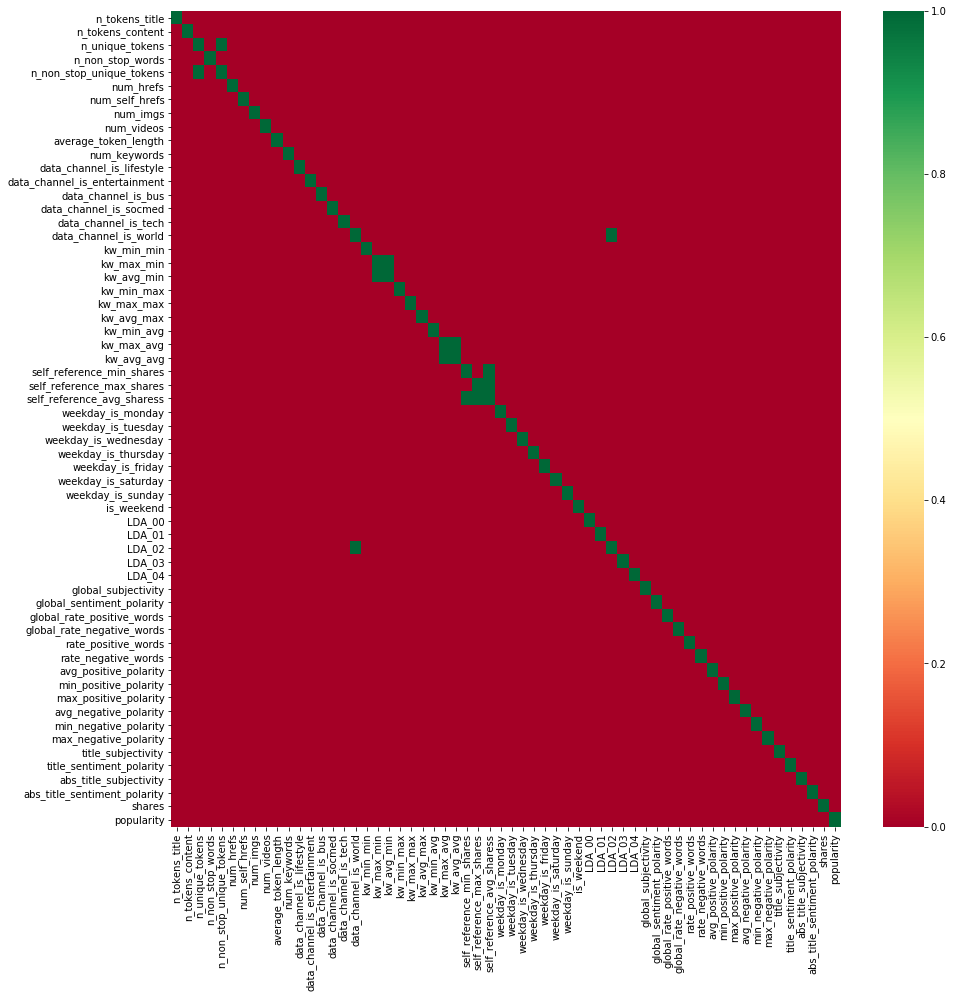

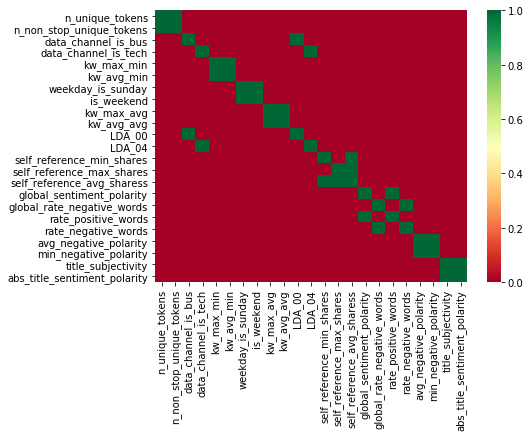

In [7]:
#4)Veiwing hihgly correlated varibales with a value greater than 0.9
cor=data.corr()
pd.set_option('max_columns', None)
x = cor[cor>0.8]
plt.figure(figsize=(15,15))
sns.heatmap(data.corr()>0.8,annot=False,cmap="RdYlGn")

data1= data[['n_unique_tokens','n_non_stop_unique_tokens','data_channel_is_bus','data_channel_is_tech','kw_max_min','kw_avg_min','weekday_is_sunday','is_weekend','kw_max_avg','kw_avg_avg','LDA_00','LDA_04','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','global_sentiment_polarity','global_rate_negative_words',
            'rate_positive_words','rate_negative_words','avg_negative_polarity','min_negative_polarity','title_subjectivity','abs_title_sentiment_polarity']]

plt.figure(figsize=(7,5))
sns.heatmap(data1.corr()>0.7,annot=False,cmap="RdYlGn")

#Removing highly correlted variables with greater than correlation greater than 80%
data= data.drop(data[["n_non_stop_unique_tokens","n_non_stop_words","kw_avg_min",'data_channel_is_world','kw_max_avg','self_reference_min_shares','self_reference_max_shares']],axis=1)

data.shape #now we have 52 variables

#Finally dropping shares from  data.- since we dont need it
data=data.drop(["shares"],axis=1)


In [8]:
#seperating numerical and categorical columns

#Data numerical has only the numerical columns- target popularity have been removed.
data_numerical=data.drop(["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday",
                  "weekday_is_friday","weekday_is_saturday","weekday_is_sunday",                  
                  "data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus",
                  "data_channel_is_socmed","data_channel_is_tech","popularity"],axis=1)

# data_cat dataframe contains the catagoricl features. 
data_cat=data[["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday",
             "weekday_is_friday","weekday_is_saturday","weekday_is_sunday",            
             "data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus",
                  "data_channel_is_socmed","data_channel_is_tech","popularity"]]

#Checking distribution of numerical attributes to decide the method of scaling
data_numerical.describe()
data_numerical.shape #39 columns
data_cat.shape #13 colums

#Checking distributions of each numerical vairbles
#data_numerical.hist(figsize=(25,25))
#we see that the the numerical attributes have different distributions- some with negative values and some with very large ranges.
#data_numerical.boxplot(figsize=(25,25))



(34133, 13)

In [9]:
#Outlier treatment on highly skewed numerical variables 

#data_large_range.dist(figsize=(25,25))
#data_large_range.hist()
#sns.distplot(data_numerical['num_videos'], hist=True, kde=False)
#data_numerical['num_videos'].describe()
#data_numerical[data_numerical['num_videos']>20].count()
##data_numerical['n_non_stop_words']=data_numerical['n_non_stop_words'].round(decimals=5)

data_numerical['kw_max_min'] = np.where(data_numerical.kw_max_min > 1000, 1000, data_numerical.kw_max_min)
data_numerical['kw_min_max'] = np.where(data_numerical.kw_min_max > 7300, 7300, data_numerical.kw_min_max)
data_numerical= data_numerical.drop(['kw_max_max'], axis=1)
data_numerical['kw_avg_max'] = np.where(data_numerical.kw_avg_max > 324200, 324200, data_numerical.kw_avg_max)
data_numerical['kw_min_avg'] = np.where(data_numerical.kw_min_avg > 1974.827586, 1974.827586, data_numerical.kw_min_avg)
data_numerical['kw_avg_avg'] = np.where(data_numerical.kw_avg_avg > 3444.746660, 3444.746660, data_numerical.kw_avg_avg)
#data_numerical['self_reference_min_shares'] = np.where(data_numerical.self_reference_min_shares >2500.000,2500.000, data_numerical.self_reference_min_shares)
#data_numerical['self_reference_max_shares'] = np.where(data_numerical.self_reference_max_shares >7600.000,7600.0000, data_numerical.self_reference_max_shares)
data_numerical['min_positive_polarity'] = np.where(data_numerical.min_positive_polarity >0.3, 0.3, data_numerical.min_positive_polarity)
#data_numerical= data_numerical.drop(['n_non_stop_words'], axis=1)
data_numerical['n_tokens_content'] = np.where(data_numerical.n_tokens_content >1400, 1400, data_numerical.n_tokens_content)
data_numerical['num_hrefs'] = np.where(data_numerical.num_hrefs >50, 50, data_numerical.num_hrefs)
data_numerical['num_imgs'] = np.where(data_numerical.num_imgs >40, 40, data_numerical.num_imgs)
data_numerical['num_self_hrefs'] = np.where(data_numerical.num_self_hrefs >30, 30, data_numerical.num_self_hrefs)
data_numerical['num_videos'] = np.where(data_numerical.num_videos >20, 20, data_numerical.num_videos)

#checking distribution after outlier treatment
#data_numerical.hist(figsize=(25,25))

#data_numerical.shape 38 columns

In [10]:
#Keeping a reference
data_numerical_copy=data_numerical

#Based on the wide distributions we choose first remove outliers using RobustScaler
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
scaler.fit(data_numerical)
data_num_scaled_1=scaler.transform(data_numerical)

#Then we put all the variables within a range of 0 to 1 using MinMaxScaler
from sklearn import preprocessing
scaler_2 = preprocessing.MinMaxScaler()
scaler_2.fit(data_num_scaled_1)
data_num_scaled=scaler_2.transform(data_num_scaled_1)

#Coverting the scaled values to a dataframe
data_num_scaled_df=(pd.DataFrame(data_num_scaled,columns=data_numerical.columns))

#Checking the distribution of the scaled numerical variables:
#data_num_scaled_df.hist(figsize=(25,25))
#data_num_scaled_df.boxplot(figsize=(25,25))

#data_num_scaled_df.shape 38 colums


In [11]:
#PCA

#1)##PCA  for LDA set of avriables
data_LDA_scaled= data_num_scaled_df[['LDA_00','LDA_01','LDA_02','LDA_03','LDA_04']]

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(data_LDA_scaled)
x_data_LDA = pca.transform(data_LDA_scaled)
x_data_LDA.shape
print(pca.explained_variance_ratio_.cumsum())

#We see that 4 out of 5 compenents retain information, hence PCA is not useful for LDA set of variables.


[0.30264796 0.5909586  0.83768331 1.         1.        ]


In [12]:
data_num_scaled_df.shape

(34133, 38)

In [13]:
#PCA for keyword related vairbales

data_key_scaled= data_num_scaled_df[['kw_min_min','kw_max_min','kw_min_max','kw_avg_max','kw_min_avg','kw_avg_avg']]

from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data_key_scaled)
x_data_key = pca.transform(data_key_scaled)
x_data_key.shape
print(pca.explained_variance_ratio_.cumsum())


#All PCA columns
PCA_key_columns = pd.DataFrame(data = x_data_key, columns = ['PC_K1', 'PC_K2','PC_K3','PC_K4','PC_K5','PC_K6'])
#PCA_key_columns

#retaining first 5(99.46% information)
PCA_key_columns_5= PCA_key_columns.drop(['PC_K6'], axis=1)
PCA_key_columns_5


[0.63268093 0.79643373 0.92634864 0.957476   0.97965243 1.        ]


,PC_K1,PC_K2,PC_K3,PC_K4,PC_K5
0,-0.787559,-0.227100,0.929848,-0.623710,0.061211
1,-0.787559,-0.227100,0.929848,-0.623710,0.061211
2,-0.787559,-0.227100,0.929848,-0.623710,0.061211
3,-0.787559,-0.227100,0.929848,-0.623710,0.061211
4,-0.787559,-0.227100,0.929848,-0.623710,0.061211
...,...,...,...,...,...
34128,0.858920,-0.021328,-0.109946,-0.030084,0.007853
34129,0.616481,0.122783,0.109116,-0.009301,-0.206659
34130,0.680531,0.008236,-0.133794,0.053219,-0.058849
34131,-0.545296,-0.673679,0.329615,-0.112379,0.103280


In [14]:
#PCA for keyword related vairbales

data_NLP_scaled= data_num_scaled_df[['global_subjectivity','global_sentiment_polarity','global_rate_positive_words','global_rate_negative_words',
                                    'rate_positive_words','rate_negative_words','avg_positive_polarity','min_positive_polarity','max_positive_polarity',
                                    'avg_negative_polarity','min_negative_polarity','max_negative_polarity','title_subjectivity','title_sentiment_polarity',
                                    'abs_title_subjectivity','abs_title_sentiment_polarity']]

pca = PCA(n_components=16)
pca.fit(data_NLP_scaled)
x_data_NLP= pca.transform(data_NLP_scaled)
x_data_NLP.shape
print(pca.explained_variance_ratio_.cumsum())

PCA_NLP_columns = pd.DataFrame(data = x_data_NLP, columns = ['PC_NLP_1', 'PC_NLP_2','PC_NLP_3','PC_NLP_4','PC_NLP_5','PC_NLP_6',
                                                             'PC_NLP_7','PC_NLP_8','PC_NLP_9','PC_NLP_10','PC_NLP_11','PC_NLP_12',
                                                            'PC_NLP_13','PC_NLP_14','PC_NLP_15','PC_NLP_16'])


#retaining 11 colums that contain 99% information
PCA_NLP_columns = PCA_NLP_columns.drop(['PC_NLP_12','PC_NLP_13','PC_NLP_14','PC_NLP_15','PC_NLP_16'],axis=1)
PCA_NLP_columns


[0.36693521 0.55065017 0.67008277 0.77995911 0.84330588 0.89074371
 0.92789776 0.94809686 0.96632806 0.98043829 0.98926936 0.9946815
 0.9974776  0.99904418 0.99989891 1.        ]


,PC_NLP_1,PC_NLP_2,PC_NLP_3,PC_NLP_4,PC_NLP_5,PC_NLP_6,PC_NLP_7,PC_NLP_8,PC_NLP_9,PC_NLP_10,PC_NLP_11
0,0.630865,-0.041940,-0.290733,-0.141333,0.002364,0.166835,-0.168107,0.107215,0.054917,0.005024,0.047261
1,-0.466852,-0.378299,0.020739,0.019022,-0.225867,-0.186696,0.027076,0.064530,-0.029560,0.020722,-0.051395
2,-0.399016,0.211720,0.239345,-0.373902,0.166306,0.242122,-0.052727,0.026705,0.002079,0.116191,0.144403
3,-0.439502,0.106983,-0.018654,0.004974,0.150799,0.072206,0.003290,0.043726,-0.036902,0.004467,-0.065131
4,0.560022,-0.173310,-0.018300,-0.477564,-0.072218,-0.049530,-0.116783,-0.043534,0.001087,0.102103,0.002757
...,...,...,...,...,...,...,...,...,...,...,...
34128,-0.243800,-0.056320,-0.062076,-0.043750,0.011076,0.033807,-0.041183,-0.000616,-0.014756,0.004639,0.027722
34129,0.557143,-0.230651,0.219266,0.106344,0.101561,0.165218,0.790894,0.013727,0.077802,0.042461,0.089363
34130,0.522213,0.197311,-0.486699,0.102582,0.036484,0.200001,-0.053271,-0.072644,-0.041585,0.038111,0.032496
34131,-0.479455,0.084627,-0.270984,0.284624,-0.197115,-0.171037,0.083179,-0.048992,-0.002546,0.010293,0.003442


In [15]:
#using the new PCA columns in our dataset

#Removing NLP and keyword related variable sets
data_num_scaled_PCA=data_num_scaled_df.drop(['kw_min_min','kw_max_min','kw_min_max','kw_avg_max','kw_min_avg','kw_avg_avg'], axis=1)
data_num_scaled_PCA=data_num_scaled_PCA.drop(['global_subjectivity','global_sentiment_polarity','global_rate_positive_words','global_rate_negative_words',
                                    'rate_positive_words','rate_negative_words','avg_positive_polarity','min_positive_polarity','max_positive_polarity',
                                    'avg_negative_polarity','min_negative_polarity','max_negative_polarity','title_subjectivity','title_sentiment_polarity',
                                    'abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)

#Concatening the 5 PCA from keyword related variables and 11 PCA from NLP related variables
Scaled_PCA_1= pd.concat([data_num_scaled_PCA,PCA_key_columns_5], axis=1)
df_final_PCA= pd.concat([Scaled_PCA_1,PCA_NLP_columns], axis=1)

#attaching the categorical variables columns.
l1=df_final_PCA.values.tolist()
l2=data_cat.values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])

df_final=pd.DataFrame(l1,columns=df_final_PCA.columns.tolist()+data_cat.columns.tolist())

In [16]:
#final dataset that will be used for modelling
#df_final.hist(figsize=(30,30))
df_final.shape  #45 variables

(34133, 45)

Text(0, 0.5, 'Error Rate')

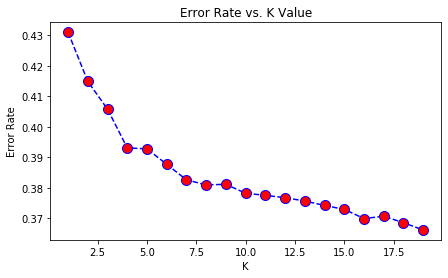

In [17]:
#KNN Model- baseline

df_final_KNN=df_final

X = df_final_KNN.drop(['popularity'],axis=1)
#drop target variable
y= df_final_KNN['popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Chaciking dimension of train and test sets
#print('Training Features Shape:', X_train.shape)
#print('Training Labels Shape:', y_train.shape)
#print('Testing Features Shape:', X_test.shape)
#print('Testing Labels Shape:', y_test.shape)

#KNN for k=1 to 20
k_range= range(1,20)
scores={}
scores_list=[]
error_rate=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    predict_test=knn.predict(X_test)
    scores[k]=metrics.accuracy_score(y_test,predict_test)
    scores_list.append(metrics.accuracy_score(y_test,predict_test))
    error_rate.append(np.mean(predict_test != y_test))

scores_list
error_rate

#Elbow plot to decide best k
plt.figure(figsize=(7,4))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [18]:
#Running Knn at K=3 

knn=KNeighborsClassifier(n_neighbors=4)

#fit model to train data
knn.fit(X_train,y_train)

#opredict on training
predict_train = knn.predict(X_train)
#print('Target on train data',predict_train) 

#accuracy on training set
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ',round(accuracy_train,2))

# predict the target on the test dataset
predict_test = knn.predict(X_test)
#print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ',round(accuracy_test,2))

print('confusion matrix on test data')
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

#for ROC and AUC values
y_pred_prob1 = knn.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
auc1 = metrics.roc_auc_score(y_test,predict_test)
auc1

accuracy_score on train dataset :  0.78
accuracy_score on test dataset :  0.59
confusion matrix on test data
[[3446 1974]
 [2181 2639]]
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      5420
           1       0.57      0.55      0.56      4820

    accuracy                           0.59     10240
   macro avg       0.59      0.59      0.59     10240
weighted avg       0.59      0.59      0.59     10240



0.5916518656887814

In [19]:
#Running- Naive Bayaes

df_final_NB=df_final

#drop target variable
X = df_final_NB.drop(['popularity'],axis=1)
y= df_final_NB['popularity']

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Chaciking dimension of train and test sets
#print('Training Features Shape:', X_train.shape)
#print('Training Labels Shape:', y_train.shape)
##print('Testing Features Shape:', X_test.shape)
#print('Testing Labels Shape:', y_test.shape)

#Create a model instance
NB_model = GaussianNB()

#fit model to train data
NB_model.fit(X_train,y_train)

#opredict on training
predict_train = NB_model.predict(X_train)
#print('Target on train data',predict_train) 

#accuracy on training set
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', round(accuracy_train,2))

# predict the target on the test dataset
predict_test = NB_model.predict(X_test)
#print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', round(accuracy_test,2))

print('confusion matrix on test data')
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

y_pred_prob2 = NB_model.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
auc2 = metrics.roc_auc_score(y_test,predict_test)
auc2

accuracy_score on train dataset :  0.62
accuracy_score on test dataset :  0.62
confusion matrix on test data
[[4354 1074]
 [2827 1985]]
              precision    recall  f1-score   support

           0       0.61      0.80      0.69      5428
           1       0.65      0.41      0.50      4812

    accuracy                           0.62     10240
   macro avg       0.63      0.61      0.60     10240
weighted avg       0.63      0.62      0.60     10240



0.6073237288748161

In [26]:
#logistic regression:

df_final_log=df_final

#drop target variable
X = df_final_log.drop(['popularity'],axis=1)
y= df_final_log['popularity']

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Run a logistic regression
log_model = LogisticRegression(penalty='l2',solver='liblinear', random_state=101, C=10) 

#fit model to train
log_model.fit(X_train,y_train)
#log_model.classes_

#predict on training
predict_train = log_model.predict(X_train)
print('Target on train data',predict_train) 

#accuracy on training set
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = log_model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

print('confusion matrix on test data')
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(log_model, X, y, cv=cv)
scores = pd.Series(scores)
print(scores.min(), scores.mean(), scores.max())

#AUC ROC
y_pred_prob3 = log_model.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)
auc3 = metrics.roc_auc_score(y_test,predict_test)
auc3

Target on train data [1 0 1 ... 0 0 0]
accuracy_score on train dataset :  0.6489766877328088
Target on test data [0 0 0 ... 1 1 0]
accuracy_score on test dataset :  0.64296875
confusion matrix on test data
[[3846 1582]
 [2074 2738]]
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      5428
           1       0.63      0.57      0.60      4812

    accuracy                           0.64     10240
   macro avg       0.64      0.64      0.64     10240
weighted avg       0.64      0.64      0.64     10240

0.6248534583821805 0.6463736715677556 0.6684241359109548


0.6387712247261973

In [ ]:
#Grid search on SVM
  
# defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf','poly','sigmoid','linear'],
             'degree': [2,3,5,7]}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
# fitting the model for grid search 
grid.fit(X_train, y_train)

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

In [ ]:
#Best SVM model

df_final_SVM=df_final

X = df_final_SVM.drop(['popularity'],axis=1)
#drop target variable
y= df_final_SVM['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Chaciking dimension of train and test sets
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', gamma=0.1, C=10, probability=True)
svclassifier.fit(X_train, y_train)

#on training
predict_train = svclassifier.predict(X_train)
print('Target on train data',predict_train) 
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = svclassifier.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

y_pred = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

#AUC ROC
y_pred_prob4 = svclassifier.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)
auc4 = metrics.roc_auc_score(y_test,predict_test)
auc4

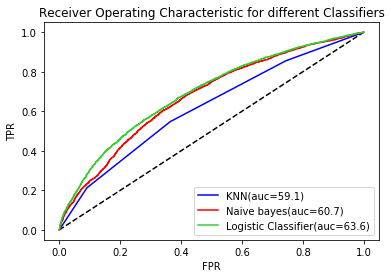

In [25]:
#ROC for all classfiers
import matplotlib.pyplot as plt

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "KNN(auc=59.1)", color='blue')
plt.plot(fpr2, tpr2, label= "Naive bayes(auc=60.7)", color='red')
plt.plot(fpr3, tpr3, label= "Logistic Classifier(auc=63.6)", color= 'limegreen')
plt.plot(fpr4, tpr4, label= "SVM(auc=64.5)", color='orange')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic for different Classifiers')
plt.show()